In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import tensorflow as tf
import os
from config.config import LSTM_DATA_DIR, LSTM_MODELS_DIR, LSTM_CALIBRATED_DIR, OBSERVACIONS_DIR, OBSERVACIONS_FILTRAT_DIR
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import keras_tuner as kt
import joblib
from tensorflow.keras.layers import Dropout
import keras.backend as K

In [23]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
"""
SENSE ELIMINAR MOSTRES INCORRECTES, ÚNICAMENT SUBSTITUINT PER LA PREDICCIO SWAT
"""

"""
merged_train_all_stations = []
merged_val_all_stations = []
merged_test_all_stations = []

n_input = 150

n_features = 18
#n_features = 3

train_normalization_features = []

#get all the files in the directory
files = os.listdir(LSTM_DATA_DIR)

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(LSTM_DATA_DIR / file))

        #convert datetime to timestamp and make it the index
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

        #split between tain, validation and test
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]


        #Create the generator
        #X_train = train_df.values
        X_train = train_df.drop('Flow', axis=1).values
        y_train = train_df['Flow'].values
        
        #X_val = val_df.values
        X_val = val_df.drop('Flow', axis=1).values
        y_val = val_df['Flow'].values


        #X_test = test_df.values
        X_test = test_df.drop('Flow', axis=1).values
        y_test = test_df['Flow'].values

        #store data for normalization
        train_normalization_features.extend(X_train)

        train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=1)
        val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=1)
        test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=1)


        #Get [([info day 1, ..., info day n], flow observation)]
        merged_train = [(sample[0][0], sample[1][0]) for sample in train_generator]
        merged_val = [(sample[0][0], sample[1][0]) for sample in val_generator]
        merged_test = [(sample[0][0], sample[1][0]) for sample in test_generator]


        merged_train_all_stations.extend(merged_train)
        merged_val_all_stations.extend(merged_val)
        merged_test_all_stations.extend(merged_test)
    
"""

'\nmerged_train_all_stations = []\nmerged_val_all_stations = []\nmerged_test_all_stations = []\n\nn_input = 150\n\nn_features = 18\n#n_features = 3\n\ntrain_normalization_features = []\n\n#get all the files in the directory\nfiles = os.listdir(LSTM_DATA_DIR)\n\n#read all the files that are csv\nfor file in files:\n    if file.endswith(".csv"):\n        df = pd.read_csv(os.path.join(LSTM_DATA_DIR / file))\n\n        #convert datetime to timestamp and make it the index\n        df[\'datetime\'] = pd.to_datetime(df[\'datetime\'])\n        df = df.set_index(\'datetime\')\n\n        #split between tain, validation and test\n        n = len(df)\n        train_df = df[0:int(n*0.7)]\n        val_df = df[int(n*0.7):int(n*0.9)]\n        test_df = df[int(n*0.9):]\n\n\n        #Create the generator\n        #X_train = train_df.values\n        X_train = train_df.drop(\'Flow\', axis=1).values\n        y_train = train_df[\'Flow\'].values\n        \n        #X_val = val_df.values\n        X_val = val_

In [25]:
"""
ELIMINAR FINESTRES DE TEMPS ON EL VALOR A PREDIR ES INCORRECTE
"""
merged_train_all_stations = []
merged_val_all_stations = []
merged_test_all_stations = []

n_input = 150

n_features = 18
#n_features = 3

train_normalization_features = []

#get all the files in the directory
files = os.listdir(LSTM_DATA_DIR)

#read all the files that are csv
for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(LSTM_DATA_DIR / file))

        #convert datetime to timestamp and make it the index
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index('datetime')

        station = file.replace('_stats', '')


        #marquem com a anomalia els valors que son nans al fitxer observacions_filtrat pero no al fitxer observacions original
        df_observacions_originals = pd.read_csv(os.path.join(OBSERVACIONS_DIR / station), parse_dates = ['Date'])
        df_observacions_filtrades = pd.read_csv(os.path.join(OBSERVACIONS_FILTRAT_DIR / station), parse_dates = ['Date'])

        df_observacions_originals.rename(columns = {'Date': 'ds', 'Flow': 'y_original'}, inplace = True)
        df_observacions_filtrades.rename(columns = {'Date': 'ds', 'Flow': 'y_original_filtrades'}, inplace = True)

        df_observacions_originals.set_index('ds', inplace = True)
        df_observacions_filtrades.set_index('ds', inplace = True)


        #merge on index 
        df = pd.concat([df, df_observacions_originals, df_observacions_filtrades], axis=1)

        #add column is anomaly, if y_original is not na and y_original_filtrades is na, then is anomaly
        df['is_anomaly'] = df['y_original'].notna() & df['y_original_filtrades'].isna()



        #split between tain, validation and test
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.85)]
        test_df = df[int(n*0.85):]


        #Create the generator
        #X_train = train_df.values
        X_train = train_df.drop(['Flow', 'is_anomaly', 'y_original', 'y_original_filtrades'], axis=1).values
        y_train = train_df[['Flow', 'is_anomaly']].values
        
        #X_val = val_df.values
        X_val = val_df.drop(['Flow', 'is_anomaly', 'y_original', 'y_original_filtrades'], axis=1).values
        y_val = val_df[['Flow', 'is_anomaly']].values


        #X_test = test_df.values
        X_test = test_df.drop(['Flow', 'is_anomaly', 'y_original', 'y_original_filtrades'], axis=1).values
        y_test = test_df[['Flow', 'is_anomaly']].values

        #store data for normalization
        train_normalization_features.extend(X_train)

        train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=1)
        val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=1)
        test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=1)


        #Get [([info day 1, ..., info day n], flow observation)]
        merged_train = [(sample[0][0], sample[1][0][0]) for sample in train_generator if not sample[1][0][1]]
        merged_val = [(sample[0][0], sample[1][0][0]) for sample in val_generator if not sample[1][0][1]]
        merged_test = [(sample[0][0], sample[1][0][0]) for sample in test_generator if not sample[1][0][1]]


        merged_train_all_stations.extend(merged_train)
        merged_val_all_stations.extend(merged_val)
        merged_test_all_stations.extend(merged_test)


In [26]:
scaler = StandardScaler()
scaler.fit(train_normalization_features)

StandardScaler()

In [27]:
#shuffle the data
#np.random.shuffle(merged_train_all_stations)
#np.random.shuffle(merged_val_all_stations)

X_train, y_train = zip(*merged_train_all_stations)
X_val, y_val = zip(*merged_val_all_stations)
X_test, y_test = zip(*merged_test_all_stations)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [28]:
X_train.shape

(177580, 150, 18)

In [29]:
X_val.shape

(34266, 150, 18)

In [30]:
X_test.shape

(33498, 150, 18)

In [31]:
#normalize the data

X_train = np.array([scaler.transform(sample) for sample in X_train])
X_val = np.array([scaler.transform(sample) for sample in X_val])
X_test = np.array([scaler.transform(sample) for sample in X_test])

In [32]:

def model_builder(hp):

    model = Sequential()

    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=64, max_value=256, step=32)
    
    model.add(LSTM(hp_units, input_shape=(X_train.shape[1], X_train.shape[2])))

    hp_dropout = hp.Float('dropout', min_value=0, max_value=0.45, step=0.15)
    model.add(Dropout(hp_dropout))

    #add dropout layer
    model.add(Dense(1, activation = 'relu'))  #force positive values

    model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer='adam')
    #model.compile(loss='mse', optimizer='adam')

    return model



In [33]:

tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     max_trials=5,                          
                     directory='my_dir',
                     project_name='log_mse_2')




INFO:tensorflow:Reloading Tuner from my_dir\log_mse_2\tuner0.json


In [34]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)


In [35]:

tuner.search(X_train, y_train, validation_data = (X_val, y_val), batch_size = 512, epochs = 30, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete. The optimal number of units in the hidden states is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('dropout')}.")


INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the hidden states is 96 and the optimal learning rate for the optimizer is 0.3.


In [36]:
hypermodel = tuner.hypermodel.build(best_hps)

X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

# Retrain the model
#history = hypermodel.fit(X_train, y_train, epochs=best_epoch, batch_size = 32, validation_data = (X_test, y_test))
history = hypermodel.fit(X_train, y_train, epochs=30, batch_size = 512, validation_data = (X_test, y_test), callbacks=[stop_early])


hypermodel.save(LSTM_CALIBRATED_DIR / 'lstm_hypermodel_log_mse.h5')

Epoch 1/30
414/414 [==============================] - 31s 70ms/step - loss: 0.3237 - val_loss: 0.3304
Epoch 2/30
414/414 [==============================] - 49s 118ms/step - loss: 0.2060 - val_loss: 0.2986
Epoch 3/30
414/414 [==============================] - 48s 117ms/step - loss: 0.1874 - val_loss: 0.2865
Epoch 4/30
414/414 [==============================] - 47s 115ms/step - loss: 0.1772 - val_loss: 0.3004
Epoch 5/30
414/414 [==============================] - 48s 115ms/step - loss: 0.1707 - val_loss: 0.2711
Epoch 6/30
414/414 [==============================] - 47s 115ms/step - loss: 0.1606 - val_loss: 0.2789
Epoch 7/30
414/414 [==============================] - 47s 115ms/step - loss: 0.1643 - val_loss: 0.2693
Epoch 8/30
414/414 [==============================] - 47s 115ms/step - loss: 0.1538 - val_loss: 0.2648
Epoch 9/30
414/414 [==============================] - 47s 115ms/step - loss: 0.1475 - val_loss: 0.2575
Epoch 10/30
414/414 [==============================] - 47s 115ms/step - lo

In [37]:
#store the scaler
joblib.dump(scaler, LSTM_CALIBRATED_DIR / 'lstm_scaler.pkl')

['c:\\users\\joans\\onedrive\\escriptori\\master\\tfm\\tfm\\data\\lstm_calibrated\\lstm_scaler.pkl']

In [38]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)


1047/1047 [==============================] - 6s 5ms/step - loss: 0.2683
[test loss, test accuracy]: 0.2683390974998474


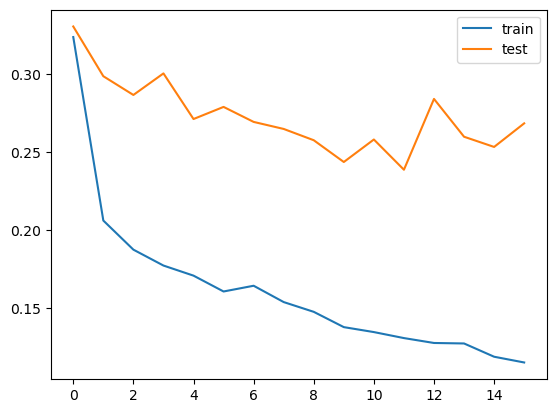

In [39]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
"""
# design network
model = Sequential()

model.add(LSTM(224, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.15))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val), verbose=1, shuffle=True, callbacks=[stop_early])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
"""

"\n# design network\nmodel = Sequential()\n\nmodel.add(LSTM(224, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.15))\nmodel.add(Dense(1))\nmodel.compile(loss='mae', optimizer='adam')\n# fit network\nhistory = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_val, y_val), verbose=1, shuffle=True, callbacks=[stop_early])\n# plot history\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='test')\nplt.legend()\nplt.show()\n"